# Advanced regridding with ESMPy

This example demonstrates some advanced regridding features in ESMPy:
- Masking
- Reading and writing weights from/to weight and RouteHandle files 


In [1]:
import ESMF
import numpy as np

# pull in some extra ESMF symbols for the sake of brevity
from ESMF import Grid, Mesh, LocStream, Field, Regrid, RegridFromFile

In [2]:
# retrieve data files used in this notebook
import os
DD = os.path.join(os.getcwd(), "ESMPy-data")
if not os.path.isdir(DD):
    os.makedirs(DD)
from ESMF.util.cache_data import cache_data_file
cache_data_file(os.path.join(DD, "ll1deg_grid.nc"))
cache_data_file(os.path.join(DD, "tas_day_CanCM4_decadal2000_r2i1p1_20010101-20101231.nc"))

True

In [3]:
import os
DD = os.path.join(os.getcwd(), "ESMPy-data")
gridfile = os.path.join(DD, "ll1deg_grid.nc")

# Create a  grid from a SCRIP formatted file
grid = Grid(filename=gridfile, filetype=ESMF.FileFormat.SCRIP, add_corner_stagger=True)

Extra dimensions (ungridded/unlimited) can be added to a *Field* to represent concepts like vertical layers and time. Extra dimensions are declared with the *ndbounds* list parameter. The *Field* allows for limiting the number of unlimited values read from file using the *timeslices* parameter. The mask can be read from the *missing_value* attribute of the *var* parameter for a CFGRID/GRIDSPEC file.

In [4]:
# Environment Canada CMIP5 climate data
grid_CanCM = ESMF.Grid(filename=os.path.join(DD, "tas_day_CanCM4_decadal2000_r2i1p1_20010101-20101231.nc"),
                 filetype=ESMF.FileFormat.GRIDSPEC, add_corner_stagger=True, add_mask=True, varname="tas")

timeslice = 12
field = ESMF.Field(grid_CanCM, ndbounds=[timeslice])

field.read(filename=os.path.join(DD, "tas_day_CanCM4_decadal2000_r2i1p1_20010101-20101231.nc"), 
           variable="tas", timeslice=timeslice)

In [5]:
# create a target field on latlon 1 degree grid, with space for time dimension
target_field = ESMF.Field(grid, ndbounds=[timeslice])

Masking can be used to retrict which values are considered in a regridding operation. The *src_mask_values* and *dst_mask_values* parameters of *Regrid* are used to indicate an integer value within the mask array of a *Grid*, *Mesh* or *LocStream* that represents positions that are NOT to be considered when calculating regridding weights. It is important to note that the mask array is stored on the *Grid*, *Mesh* or *LocStream* that was used to create a *Field* (even if the mask was read from a field variable in a NetCDF file), but that the integer value(s) that represent the mask are not activated until *Regrid* is created. If any stagger location of a grid cell is masked, then the entire cell (all stagger locations) are considered masked. ESMF chose this masking strategy to allow representing several different masks on a single *Grid*, *Mesh* or *LocStream*, keyed by different integer values, that can be shared between *Fields*.

The *unmapped_action* flag allows for ignoring destination points that have no corresponding gridding information from the source. This can be useful when regridding between regional grids that do not fully overlap, or grids with lots of masked points.

In [6]:
# generate weights, note that masks read from file generally use 0 to represent masked values and 1 for non masked
regrid = ESMF.Regrid(field, target_field, regrid_method=ESMF.RegridMethod.CONSERVE, 
                     unmapped_action=ESMF.UnmappedAction.IGNORE, dst_mask_values=[0])

In [7]:
# also generation a reverse Regrid to bring the data back to the original grid (for error measurement)
regrid_T= ESMF.Regrid(target_field, field, regrid_method=ESMF.RegridMethod.CONSERVE, 
                        unmapped_action=ESMF.UnmappedAction.IGNORE, src_mask_values=[0])

The *zero_region* flag will specify which portions of the source field to initialize to zero before applying the regridding weights, *SELECT* will only initialize the regions that are modified by the regridding weights. This is useful for maintaining an uninitialized value on *Field* data that does not participate in the regridding operations.

In [8]:
# Apply the weights in the Regrid/Regrid_T to regrid data from field to target_field and then back to field
target_field = regrid(field, target_field, zero_region=ESMF.Region.SELECT)
solution_CanCM = regrid_T(target_field, field, zero_region=ESMF.Region.SELECT)

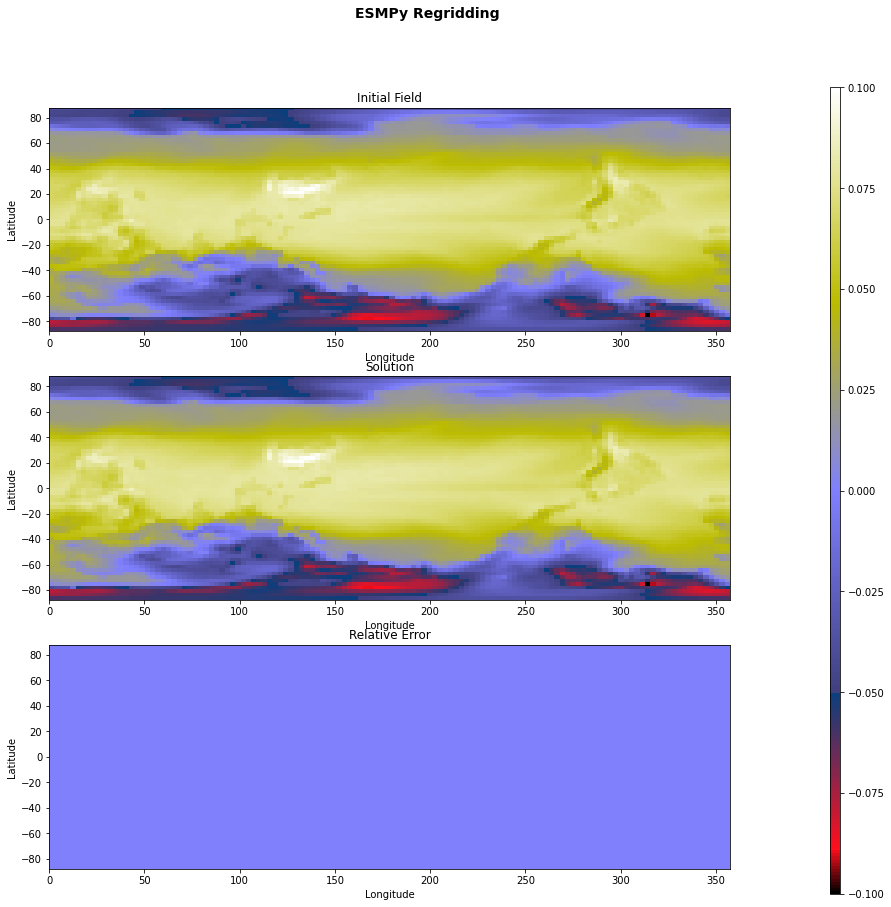

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline

ts = timeslice-1

colormap = "gist_stern"
lons = field.grid.get_coords(0)
lats = field.grid.get_coords(1)

fig = plt.figure(1, (14, 14))
fig.suptitle('ESMPy Regridding', fontsize=14, fontweight='bold')

init = np.copy(field.data[:,:,ts].T)

ax = fig.add_subplot(3, 1, 1)
im = ax.imshow(init, vmin=np.min(init),
               vmax=np.max(init), cmap=colormap, aspect='auto',
               extent=[np.min(lons), np.max(lons),
                       np.min(lats), np.max(lats)])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Initial Field")

sol = np.copy(solution_CanCM.data[:,:,ts].T)

ax = fig.add_subplot(3, 1, 2)
im1 = ax.imshow(sol, vmin=np.min(sol),
                vmax=np.max(sol), cmap=colormap, aspect='auto',
                extent=[np.min(lons), np.max(lons),
                        np.min(lats), np.max(lats)])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Solution")

relerr = np.abs(solution_CanCM.data[:,:,ts].T - field.data[:,:,ts].T)/np.abs(field.data[:,:,ts].T)

ax = fig.add_subplot(3, 1, 3)
im1 = ax.imshow(relerr, vmin=np.min(relerr),
                vmax=np.max(relerr), cmap=colormap, aspect='auto',
                extent=[np.min(lons), np.max(lons),
                        np.min(lats), np.max(lats)])
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Relative Error")

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.9, 0.1, 0.01, 0.8])
fig.colorbar(im1, cax=cbar_ax)

plt.show()

*Regrid* can also write the weights to file to read in at a later time. This is useful for speeding up initialization time (i.e. *Regrid* creation), and/or when reusing the same weights for multiple *Field* pairs.

In [10]:
# NOTE: if filename already exists, there is no option to overwrite with Regrid, RC 22
weightfile = "CanCMtoLatLon1deg.nc"
cmd = "rm -rf "+weightfile
!{cmd}

# generate weights and output them to a file
rf1 = ESMF.Regrid(field, target_field, regrid_method=ESMF.RegridMethod.CONSERVE, 
                        unmapped_action=ESMF.UnmappedAction.IGNORE, filename=weightfile)

In [11]:
cmd = "ncdump -h CanCMtoLatLon1deg.nc"
!{cmd}

netcdf CanCMtoLatLon1deg {
dimensions:
	n_s = 118096 ;
variables:
	double S(n_s) ;
	int col(n_s) ;
	int row(n_s) ;
}


*Regrid* can also write a *RouteHandle* to file. *RouteHandle* is an ESMF concept to represent regridding weights that have been stored as communication path within the context of the virtual machine employed by the current execution. Application times for weights that have been stored in a *RouteHandle* file are often an order of magnitude faster than those stored in a NetCDF weight file.

In [12]:
# generate weights and output them to a file 
routehandlefile = "CanCMtoLatLon1deg.rh"
rf2 = ESMF.Regrid(field, target_field, regrid_method=ESMF.RegridMethod.CONSERVE, 
                        unmapped_action=ESMF.UnmappedAction.IGNORE, rh_filename=routehandlefile)

In [13]:
rf1 = ESMF.RegridFromFile(field, target_field, filename=weightfile)
rf2 = ESMF.RegridFromFile(field, target_field, rh_filename=routehandlefile)

In [14]:
import time

t0 = time.time()
target_field1 = rf1(field, target_field)
t1 = time.time()
target_field2 = rf2(field, target_field)
t2 = time.time()

print("A RouteHandle read from file can be used to apply weights ", (t1-t0)/(t2-t1), " times faster than a RouteHandle read from a weight file in this simple example. The speedup is magnified with larger problem sizes.")

A RouteHandle read from file can be used to apply weights  1.2035722586758686  times faster than a RouteHandle read from a weight file in this simple example. The speedup is magnified with larger problem sizes.
